In [1]:
import os, glob, time, math, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
DATA_DIR = r"C:\Programming\Prodigy Infotech\Data\04_leapGestRecog"   # <-- change to your path (folder with 00..09)
SAVE_DIR = r"C:\Programming\Prodigy Infotech\PRODIGY_ML_04"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 6
EPOCHS = 25
LR = 3e-4
USE_RESNET18 = False  # True: use ResNet18, False: use SmallCNN   
IMG_SIZE = 96         
PATIENCE = 6          
LABEL_NAMES = [str(i) for i in range(10)] 

In [4]:
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

In [5]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=12, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomErasing(p=0.25, scale=(0.01, 0.05), ratio=(0.3, 3.3))
])


eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

print(f"Train Transforms : {train_tfms}")
print(f"Evaluation Transforms : {eval_tfms}")

Train Transforms : Compose(
    Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=True)
    RandomAffine(degrees=[-12.0, 12.0], translate=(0.05, 0.05), scale=(0.9, 1.1), shear=[-8.0, 8.0])
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
    RandomErasing(p=0.25, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
)
Evaluation Transforms : Compose(
    Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [6]:
train_subjects = list(range(0, 8))  # 00..07
val_subjects   = [8]                # 08
test_subjects  = [9] 

In [7]:
class LeapGestDataset(Dataset):
    def __init__(self, data_dir, subjects, transform=None):
        self.items = []
        self.transform = transform
        data_dir = Path(data_dir)

        # First, discover class names from subject "00"
        example_subj = data_dir / f"{subjects[0]:02d}"
        gesture_dirs = sorted([d for d in example_subj.iterdir() if d.is_dir()])
        self.class_names = [g.name for g in gesture_dirs]
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}

        # Now collect items
        for s in subjects:
            subj_dir = data_dir / f"{s:02d}"
            for cls_dir in sorted(subj_dir.iterdir()):
                if not cls_dir.is_dir():
                    continue
                label = self.class_to_idx[cls_dir.name]
                for img_path in cls_dir.glob("*.png"):
                    self.items.append((img_path, label))

        random.shuffle(self.items)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("L")
        if self.transform:
            img = self.transform(img)
        if img.ndim == 2:
            img = img.unsqueeze(0)
        return img, label


In [8]:
train_ds = LeapGestDataset(DATA_DIR, train_subjects, transform=train_tfms)
val_ds   = LeapGestDataset(DATA_DIR, val_subjects,   transform=eval_tfms)
test_ds  = LeapGestDataset(DATA_DIR, test_subjects,  transform=eval_tfms)

In [9]:
print(f"Train images: {len(train_ds)}")
print(f"Val images: {len(val_ds)}")
print(f"Test images: {len(test_ds)}")

Train images: 16000
Val images: 2000
Test images: 2000


In [10]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)#,num_workers=NUM_WORKERS, pin_memory=True,prefetch_factor=2,persistent_workers=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)#,num_workers=NUM_WORKERS, pin_memory=True,prefetch_factor=2,persistent_workers=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)#,num_workers=NUM_WORKERS, pin_memory=True,prefetch_factor=2,persistent_workers=True)

In [11]:
for x,y in train_loader:
    print(x.shape,y.shape)
    break

torch.Size([32, 1, 96, 96]) torch.Size([32])


In [12]:
def resnet18_1ch(num_classes=10):
    m = models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

In [13]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (resnet18_1ch(10) if USE_RESNET18 else SmallCNN(10)).to(device)

In [15]:
def run_epoch(model, loader, optimizer=None, scaler=None, device="cuda",epoch=0):
    is_train = optimizer is not None
    model.train(is_train)
    total, correct, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    # Wrap loader with tqdm
    loop = tqdm(loader, desc=f"EPOCH : {epoch}/{EPOCHS} Training" if is_train else "Validation", leave=False)
    for imgs, labels in loop:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                logits = model(imgs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_sum += loss.item() * labels.size(0)
        # Update tqdm bar with live stats
        loop.set_postfix({
            "loss": f"{loss_sum/total:.4f}",
            "acc": f"{correct/total:.4f}"
        })
    return loss_sum/total, correct/total

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.amp.GradScaler(enabled=(device.type=="cuda"))

In [17]:
best_val_acc = 0.0
epochs_no_improve = 0
best_path = os.path.join(SAVE_DIR, f"best_{'resnet18' if USE_RESNET18 else 'smallcnn'}_{IMG_SIZE}.pth")

In [18]:
print(f"Train Length: {len(train_ds)} | Val Length: {len(val_ds)} | Test Length: {len(test_ds)}")

Train Length: 16000 | Val Length: 2000 | Test Length: 2000


In [19]:
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, optimizer, scaler, device=device, epoch=epoch)
    val_loss, val_acc = run_epoch(model, val_loader, device=device, epoch=epoch)
    scheduler.step()
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f} acc={val_acc*100:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({"model": model.state_dict(),"optmizer":optimizer.state_dict(),"scheduler":scheduler.state_dict(),"scaler":scaler,"epoch":EPOCHS}, best_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping.")
            break
print(f"Best val acc: {best_val_acc*100:.2f}% | ckpt: {best_path}")

[01/25] train_loss=0.2395 acc=92.54% | val_loss=0.8729 acc=77.90%


[02/25] train_loss=0.0611 acc=98.11% | val_loss=1.0869 acc=76.75%


[03/25] train_loss=0.0469 acc=98.57% | val_loss=0.7680 acc=74.20%


[04/25] train_loss=0.0376 acc=98.89% | val_loss=0.4525 acc=83.00%


[05/25] train_loss=0.0343 acc=99.04% | val_loss=0.7530 acc=83.05%


[06/25] train_loss=0.0314 acc=98.97% | val_loss=0.4112 acc=83.40%


[07/25] train_loss=0.0221 acc=99.35% | val_loss=0.4245 acc=85.45%


[08/25] train_loss=0.0202 acc=99.40% | val_loss=0.3599 acc=89.45%


[09/25] train_loss=0.0268 acc=99.19% | val_loss=0.2396 acc=92.60%


[10/25] train_loss=0.0157 acc=99.50% | val_loss=0.8837 acc=74.95%


[11/25] train_loss=0.0130 acc=99.58% | val_loss=0.3272 acc=90.75%


[12/25] train_loss=0.0127 acc=99.59% | val_loss=0.3201 acc=92.90%


[13/25] train_loss=0.0129 acc=99.60% | val_loss=0.5959 acc=86.55%


[14/25] train_loss=0.0094 acc=99.69% | val_loss=0.3106 acc=93.20%


[15/25] train_loss=0.0084 acc=99.76% | val_loss=0.2742 acc=93.20%


[16/25] train_loss=0.0063 acc=99.78% | val_loss=0.3117 acc=91.95%


[17/25] train_loss=0.0074 acc=99.74% | val_loss=0.5450 acc=84.85%


[18/25] train_loss=0.0067 acc=99.78% | val_loss=0.2782 acc=92.30%


[19/25] train_loss=0.0068 acc=99.78% | val_loss=0.3530 acc=91.80%


[20/25] train_loss=0.0042 acc=99.86% | val_loss=0.3217 acc=92.80%
Early stopping.
Best val acc: 93.20% | ckpt: C:\Programming\Prodigy Infotech\PRODIGY_ML_04\best_resnet18_96.pth


In [20]:
# Evaluation
ckpt = torch.load(best_path, map_location=device,weights_only = False)
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [21]:
model.eval()
all_labels, all_preds = [], []
with torch.inference_mode():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy().tolist()
        all_preds += preds
        all_labels += labels.numpy().tolist()

In [22]:
print(classification_report(all_labels, all_preds, target_names=LABEL_NAMES, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       200
           1     1.0000    1.0000    1.0000       200
           2     1.0000    0.6700    0.8024       200
           3     0.7519    1.0000    0.8584       200
           4     1.0000    1.0000    1.0000       200
           5     1.0000    1.0000    1.0000       200
           6     1.0000    1.0000    1.0000       200
           7     1.0000    1.0000    1.0000       200
           8     1.0000    1.0000    1.0000       200
           9     1.0000    1.0000    1.0000       200

    accuracy                         0.9670      2000
   macro avg     0.9752    0.9670    0.9661      2000
weighted avg     0.9752    0.9670    0.9661      2000



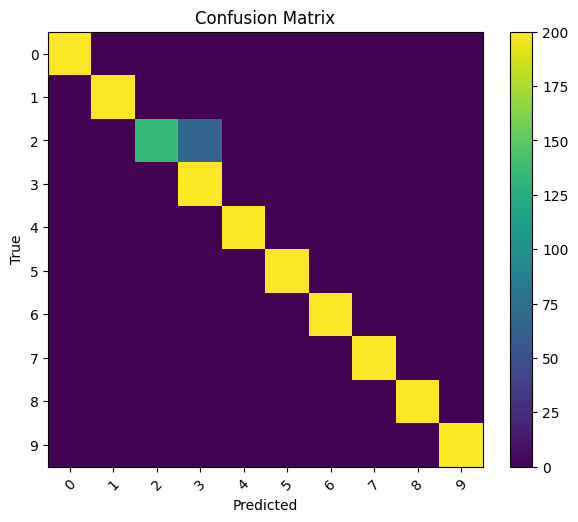

In [23]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(10), LABEL_NAMES, rotation=45)
plt.yticks(range(10), LABEL_NAMES)
plt.tight_layout()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()